In [ ]:
tfds.list_builders()

In [1]:
import os
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random


import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_io as tfio
from tensorflow import keras
import tensorflow_probability as tfp 

import librosa

tfd = tfp.distributions
config = dict()
config['verbose'] = 1
AUTOTUNE = tf.data.AUTOTUNE

In [2]:
from IPython.display import Audio
%matplotlib notebook
%matplotlib inline
print(tf.__version__)

2.4.0


In [3]:
# load dataset
ds, ds_info = tfds.load('gtzan', with_info=True, download=False, split=['train'])
ds = ds[0]

ds_info

tfds.core.DatasetInfo(
    name='gtzan',
    full_name='gtzan/1.0.0',
    description="""
    The dataset consists of 1000 audio tracks each 30 seconds long.
    It contains 10 genres, each represented by 100 tracks.
    The tracks are all 22050Hz Mono 16-bit audio files in .wav format.
    
    The genres are:
    
    * blues
    * classical
    * country
    * disco
    * hiphop
    * jazz
    * metal
    * pop
    * reggae
    * rock
    """,
    homepage='http://marsyas.info/index.html',
    data_path='C:\\Users\\BOUBAW\\tensorflow_datasets\\gtzan\\1.0.0',
    download_size=1.14 GiB,
    dataset_size=3.71 GiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=tf.int64),
        'audio/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('audio', 'label'),
    splits={
        'train': <SplitInfo num_examples=1000, num_shards=32>,
    },
    citation="""@misc{tzanetakis_

In [5]:
sample = ds.as_numpy_iterator().next()
sample['audio'].shape

(661504,)

In [6]:
for i, elem in enumerate(ds.as_numpy_iterator()):
    if i < 10:
        print(elem['audio'].shape)
    else:
        break

(661504,)
(661794,)
(661504,)
(661794,)
(661794,)
(661794,)
(661794,)
(661794,)
(661504,)
(661504,)


In [7]:
audio = elem['audio'][:331397]

Audio(audio, rate=22050)

In [11]:
data = ds
taking = 100
data = data.take(taking)  # Only take a single example

if taking<101:
    data_np_iterator = data.as_numpy_iterator() # create numpy iterator
    df = tfds.as_dataframe(data, ds_info) # save as df

    df

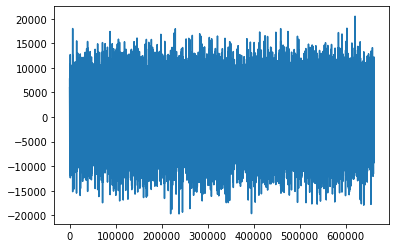

In [9]:
tensor = df['audio'][8]

plt.figure()
plt.plot(tensor)
plt.show()

In [4]:
def decode_audio(audio_binary):
    audio, rate = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1), rate

config['noise_root'] = 'C:/Users/BOUBAW/tensorflow_datasets/fsd/1.0.0'
def get_waveform(x):
    audio_binary = tf.io.read_file(config['noise_root']+os.sep+x['noise'])
    audio, sample_rate = tf.audio.decode_wav(audio_binary,
                                             desired_channels=1,
                                             desired_samples=config['sample_rate'])
    audio = tf.squeeze(audio, axis=-1)
    
    return {'noise_wav': audio,
            'noise_label': x['label'],
            'rate': sample_rate}

    
def get_label(x):
#     x.decode()
    return noise_data.loc[x]['label']

In [5]:
config['noise_path'] = 'C:/Users/BOUBAW/tensorflow_datasets/fsd/meta/test_post_competition_scoring_clips.csv'
config['sample_rate'] = 22050

# build noise dataset
meta = pd.read_csv(config['noise_path'], index_col='fname')
labels = meta.label

noise_classes = ['Meow', 'Cough', 'Computer_keyboard', 'Telephone',
                 'Keys_jangling', 'Knock', 'Microwave_oven', 'Finger_snapping',
                 'Bark', 'Laughter', 'Drawer_open_or_close']

noise_data = meta.loc[meta['label'].isin(noise_classes)].index.values
random.shuffle(noise_data)
size = ds.cardinality()
extended_noise = noise_data
while len(extended_noise) < size:
    extended_noise = np.concatenate([extended_noise, noise_data])

random.shuffle(extended_noise)

noise_ds2 = tf.data.Dataset.from_tensor_slices({'noise': extended_noise,
                                              'label': [0]*len(extended_noise)})

waveform_ds2 = noise_ds2.map(lambda x: get_waveform(x), num_parallel_calls=AUTOTUNE)
waveform_ds2.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=1071>

In [18]:
config['nfft'] = 512
config['window'] = 512
config['stride'] = 256
config['mels'] = 128
config['fmin_mels'] = 0
config['fmax_mels'] = 8000
config['time_mask'] = 10
config['freq_mask'] = 10 

#============================== PREPROCESSING ==============================

def wrapper_cast(x):
    x['audio'] = tf.cast(x['audio'], tf.float32)# / 32768.0
    x['noise_wav'] = tf.cast(x['noise_wav'], tf.float32)# / 32768.0
    return x

def wrapper_cast_label(x):
    x['label'] = tf.cast(x['label'], tf.int64)
    return x

def wrapper_spect(x, light=True):
    x['spectrogram'] = tfio.experimental.audio.spectrogram(x['input'],
                                                           nfft=config['nfft'],
                                                           window=config['window'],
                                                           stride=config['stride'])
#     x['spectrogram_sq'] = tfio.experimental.audio.spectrogram(x['input'],
#                                                            nfft=config['nfft'],
#                                                            window=config['window'],
#                                                            stride=config['stride'],
#                                                            magnitude_squared=True)
    x.pop('input')
    return x

def wrapper_mel(x, db=False, light=True):
    x['mel'] = tfio.experimental.audio.melscale(x['spectrogram'],
                                                rate=config['sample_rate'],
                                                mels=config['mels'],
                                                fmin=config['fmin_mels'],
                                                fmax=config['fmax_mels'])
    if db: #to be implemented with noise
        x['db_mel'] = tfio.experimental.audio.dbscale(x['mel'], top_db=80)
    
    x.pop('spectrogram')
    return x

def cut_15(signal):
#     start = tfd.Categorical([1]*661000).sample(int(1))
    start = np.random.randint(0, int(len(signal)/2))
    signal = signal[start:start+int(len(signal)/2)]
    return signal

def wrapper_cut_15(x):
    out = tf.py_function(cut_15, [x['audio']], [tf.float32])
    x['audio'] = tf.squeeze(out)
    return x

#============================== AUGMENTATION ==============================

def wrapper_fade(x):
    x['audio'] = tfio.experimental.audio.fade(x['audio'], fade_in=100000, fade_out=100000, mode="logarithmic")
    return x

def wrapper_trim(x):
    position = tfio.experimental.audio.trim(x['audio'], axis=0, epsilon=0.1)
    start = position[0]
    stop = position[1]
    x['audio'] = x['audio'][start:stop]
    return x

def wrapper_mask(x, db=False):
    # freq masking
    x['mel'] = tfio.experimental.audio.freq_mask(x['mel'],
                                                 param=config['freq_mask'])
    # Time masking
    x['mel'] = tfio.experimental.audio.time_mask(x['mel'],
                                                 param=config['time_mask'])
    if db:
        x['db_mel'] = tfio.experimental.audio.freq_mask(x['db_mel'], param=10)
        x['db_mel'] = tfio.experimental.audio.time_mask(x['db_mel'], param=10)
    return x


def wrapper_nat_noise(x, threshold, beta):
    if tfd.Uniform(0, 1).sample() < threshold:
        mix = tfd.Beta(beta, beta).sample([tf.shape(x['mel'])[0], 1, 1])
        mix = tf.maximum(mix, 1 - mix)
        x['mel'] = x['mel'] * mix + x['noise_mel'] * (1 - mix)
    
    x.pop('noise_mel')
    x.pop('noise_label')
    return x
    
    

def wrapper_roll(x):
    x['mel'] = tf.roll(x['mel'], 
                       tf.random.uniform((), minval=-15, maxval=15, dtype=tf.dtypes.int32),
                       axis=1)
    return x
    


def pad_noise(signal, noise):
    if len(signal)>len(noise):
        _, noise = tf.keras.preprocessing.sequence.pad_sequences([signal[:int(len(signal)/4)], noise],
                                                                  maxlen=None,
                                                                  dtype='float32',
                                                                  padding='pre',
                                                                  truncating='pre',
                                                                  value=0.0)
    signal, noise = tf.keras.preprocessing.sequence.pad_sequences([signal, noise],
                                                                  maxlen=None,
                                                                  dtype='float32',
                                                                  padding='post',
                                                                  truncating='pre',
                                                                  value=0.0)
    return [signal, noise]

def wrapper_pad_noise(x):
    out = tf.py_function(pad_noise, [x['audio'], x['noise_wav']], [tf.float32, tf.float32])
    x['audio'], x['noise_wav'] = out
    return x

def get_noise_from_sound(signal,noise,SNR):
    RMS_s=math.sqrt(np.mean(signal**2))
    #required RMS of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    
    #current RMS of noise
    RMS_n_current=math.sqrt(np.mean(noise**2))
    noise=noise*(RMS_n/RMS_n_current)
    
    return noise

def wrapper_mix_noise(x, SNR):
    out = tf.py_function(get_noise_from_sound,
                         [x['audio'], x['noise_wav'], SNR],
                         [tf.float32])
    x['input'] = tf.squeeze(out)+x['audio']
    x.pop('audio')
    x.pop('noise_wav')
    return x

def wrapper_merge_features(ds1, ds2):
    ds1.update(ds2)
    return ds1

def wrapper_mfcc(x):
    x['mfcc'] = tf.signal.mfccs_from_log_mel_spectrograms(x['mel'])
    
    return x

def mixup_one_hot(x, l, beta):
    """
    see https://arxiv.org/pdf/1710.09412.pdf
    Apply mixup to a batch of spectrograms.
    Args:
      x: An audio spectogram.
      l: One-hot encoded ground truth.
      param: Parameter of time masking.
    Returns:
      A tensor of batched spectrograms.
    """
    mix = tfd.Beta(beta, beta).sample([tf.shape(x)[0], 1, 1])
    mix = tf.maximum(mix, 1 - mix)
    xmix = x * mix + x[::-1] * (1 - mix)
    lmix = l * mix[:, :, 0] + l[::-1] * (1 - mix[:, :, 0])
    return [xmix, lmix]

def wrapper_mixup_one_hot(x):
    out = tf.py_function(mixup_one_hot, [x['mel'], x['label'], 0.5], [tf.int64, tf.int64])
    x['mel'], x['label'] = out
    return x

def wrapper_log_mel(x):
    x['mel'] = tf.math.log(1 + x['mel'])
    
    return x

def pitch_shift_data(wave_data):

    wave_data = wave_data.numpy()
    random_shift = np.random.randint(low=-3, high=3)
    wave_data = librosa.effects.pitch_shift(wave_data, config['sample_rate'], 
                                            random_shift, bins_per_octave=12)
    return wave_data

def wrapper_change_pitch(x):
    out = tf.py_function(pitch_shift_data, [x['audio']], tf.float32)
    x['audio'] = out
    return x

In [19]:
config['noise_threshold'] = 1 # add noise to only 0.3
config['beta'] = 0.5 # noise strength when mixing mel spectrograms
config['SNR'] = 5

taking = 50
ds = data.take(taking)

# zip noise dataset
ds = tf.data.Dataset.zip((ds, waveform_ds2))
# merge features into one featureDict
ds = ds.map(lambda x, y: wrapper_merge_features(x, y), num_parallel_calls=AUTOTUNE)

# wav-level
ds = ds.map(lambda x: wrapper_cast(x), num_parallel_calls=AUTOTUNE)
ds = ds.map(lambda x: wrapper_cut_15(x), num_parallel_calls=AUTOTUNE)
ds = ds.map(lambda x: wrapper_change_pitch(x), num_parallel_calls=AUTOTUNE)
ds = ds.map(lambda x: wrapper_trim(x), num_parallel_calls=AUTOTUNE) # do we wanna trim?
ds = ds.map(lambda x: wrapper_fade(x), num_parallel_calls=AUTOTUNE)
ds = ds.map(lambda x: wrapper_pad_noise(x), num_parallel_calls=AUTOTUNE)
ds = ds.map(lambda x: wrapper_mix_noise(x, SNR=config['SNR']), num_parallel_calls=AUTOTUNE)

In [20]:
config['shuffle_batch_size'] = 64

# spect-level
ds = ds.map(lambda x: wrapper_spect(x), num_parallel_calls=AUTOTUNE)
ds = ds.map(lambda x: wrapper_mel(x, db=0), num_parallel_calls=AUTOTUNE) # Convert to mel-spectrogram
ds = ds.map(lambda x: wrapper_log_mel(x), num_parallel_calls=AUTOTUNE)
ds = ds.map(lambda x: wrapper_mfcc(x), num_parallel_calls=AUTOTUNE)
ds = ds.map(lambda x: wrapper_roll(x), num_parallel_calls=AUTOTUNE) # do we wanna roll? (yes)
ds = ds.map(lambda x: wrapper_mask(x, db=0), num_parallel_calls=AUTOTUNE)
# ds = ds.map(lambda x: wrapper_cast_label(x), num_parallel_calls=AUTOTUNE)
# ds = ds.batch(64).map(lambda x: wrapper_mixup_one_hot(x), num_parallel_calls=AUTOTUNE).unbatch()
ds = ds.shuffle(buffer_size=config['shuffle_batch_size'])


config['verbose'] = 0

if config['verbose']:
    print(ds.as_numpy_iterator().next())

In [21]:
s = ds.as_numpy_iterator().next()

In [22]:
s['mfcc'].shape

(1293, 128)

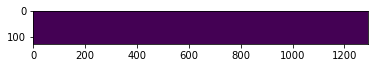

In [21]:
plt.imshow(s['mel'].T)

In [112]:
audios = []
for line in ds.as_numpy_iterator():
    audios.append(line['mel'])

# Audio(audios[25], rate=22050)

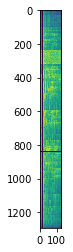

In [114]:
plt.imshow(audios[20])

In [102]:
s = audios[25].reshape([-1, 1]).T

In [103]:
mel = tfio.experimental.audio.spectrogram(s,
                                          nfft=config['nfft'],
                                          window=config['window'],
                                          stride=config['stride'])[0].numpy()

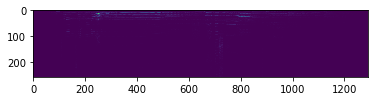

In [104]:
plt.imshow(mel.T)

In [108]:
mel = tfio.experimental.audio.melscale(mel,
                                                rate=config['sample_rate'],
                                                mels=config['mels'],
                                                fmin=config['fmin_mels'],
                                                fmax=config['fmax_mels']).numpy()

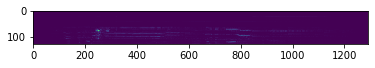

In [109]:
plt.imshow(mel.T)

In [20]:
Audio(df['input'][0], rate=22050)

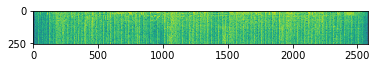

In [12]:
plt.imshow(tf.math.log(element['spectrogram']).numpy().T)

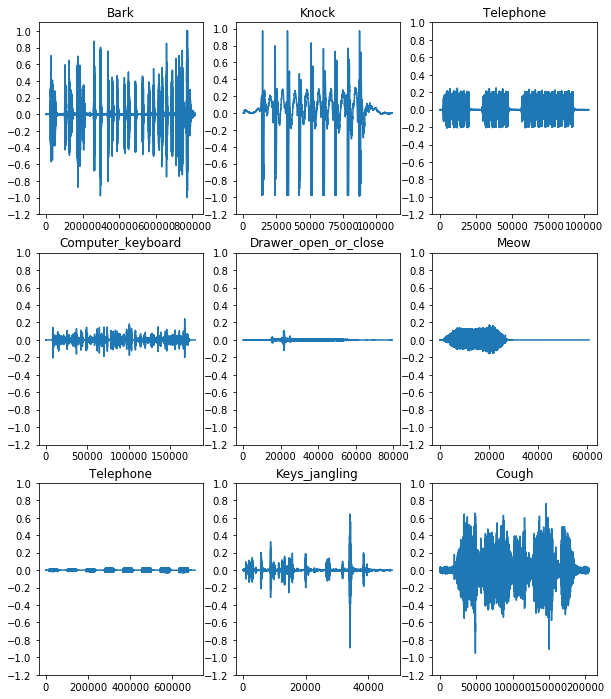

In [22]:
# rows = 3
# cols = 3
# n = rows*cols
# fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
# for i, (audio, label, _) in enumerate(waveform_ds.take(n)):
#     r = i // cols
#     c = i % cols
#     ax = axes[r][c]
#     ax.plot(audio.numpy())
#     ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
#     label = label.numpy().decode('utf-8')
#     ax.set_title(label)

# plt.show()

In [ ]:
signal_noise=signal+noise

In [23]:
print("SNR = " + str(20*np.log10(math.sqrt(np.mean(signal**2))/math.sqrt(np.mean(noise**2)))))

plt.plot(signal)
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.show()

plt.plot(signal_noise)
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.show()

NameError: name 'signal' is not defined

In [ ]:
Audio(signal_noise, rate=22050)

In [ ]:
Audio(signal_noise, rate=22050)

## TODO 
* cut added noise to max 5 seconds and make sure they have noise in them
* transform obtained data as above
* Mix songs from same genre using the Beta distribution
* Open?: Play songs faster - in the spectrograms
* Open?: Take out human voice? 

## Natrual Noising

In [109]:
# set seed
config['seed'] = 0
tf.random.set_seed(config['seed'])
np.random.seed(config['seed'])

# load dataset
ds, ds_info = tfds.load('gtzan', with_info=True, download=False, split=['train'])
ds = ds[0]
ds = ds.take(10)

ds_info

tfds.core.DatasetInfo(
    name='gtzan',
    full_name='gtzan/1.0.0',
    description="""
    The dataset consists of 1000 audio tracks each 30 seconds long.
    It contains 10 genres, each represented by 100 tracks.
    The tracks are all 22050Hz Mono 16-bit audio files in .wav format.
    
    The genres are:
    
    * blues
    * classical
    * country
    * disco
    * hiphop
    * jazz
    * metal
    * pop
    * reggae
    * rock
    """,
    homepage='http://marsyas.info/index.html',
    data_path='C:\\Users\\BOUBAW\\tensorflow_datasets\\gtzan\\1.0.0',
    download_size=1.14 GiB,
    dataset_size=3.71 GiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=tf.int64),
        'audio/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('audio', 'label'),
    splits={
        'train': <SplitInfo num_examples=1000, num_shards=32>,
    },
    citation="""@misc{tzanetakis_

In [113]:
config['noise_threshold'] = 0.7
config['sampling_rate'] = 22050
config['SNR'] = 5

def get_dataset(df):
    file_path_ds = tf.data.Dataset.from_tensor_slices(df.fname)
    label_ds = tf.data.Dataset.from_tensor_slices(df.label)
    return tf.data.Dataset.zip((file_path_ds, label_ds))

def load_audio(file_path, label):
    # Load one second of audio at 44.1kHz sample-rate
    audio = tf.io.read_file(root+os.sep+file_path)
    audio, sample_rate = tf.audio.decode_wav(audio,
                                             desired_channels=1,
                                             desired_samples=22050)
    return audio, label

def prepare_for_training(ds_train, shuffle_buffer_size=1024, batch_size=64):
    # Load and decode audio from file paths
    ds_train = ds_train.map(load_audio, num_parallel_calls=AUTOTUNE)
    return ds

def add_natural_noise(signal):
    
        # pick noise class
        noise_class = np.random.choice(noise_classes)
        # pick random noise
        noise_file = noise_data[noise_data['label'] == noise_class].sample()#.index[0]
#         print(list(noise_file.items())[0][1])
        noise_ds = get_dataset(noise_file)
        noise_ds = prepare_for_training(noise_ds)
        for elem in noise_ds:
            print(elem)
#         noise_signal = 
#         noise_signal = tf.squeeze(elem['audio'], axis=[-1]) 
        
        # load signal ========= NEED OPTIMIZATION
#         noise, _, noise_rate = t([noise_file, None])
#         noise_reading = tfio.audio.AudioIOTensor(root+os.sep+noise_file, dtype=tf.float32)
#         print(noise_reading.__getitem__(0).get_shape())
#         return noise_reading.__getitem__(0)
        noise_rate = 22050
#         noise_reading = noise_reading[:]
#         noise = tf.squeeze(noise_reading, axis=[-1]).numpy().astype('float32')
        
#         noise = tf.cast(noise, tf.float32)
        noise = tfio.audio.resample(noise, 
                                    tf.cast(noise_rate, tf.int64),
                                    config['sampling_rate'],
                                    name=None)
        noise, signal = tf.keras.preprocessing.sequence.pad_sequences([noise, signal], 
                                                                      maxlen=None, 
                                                                      dtype='float32', 
                                                                      padding='pre',
                                                                      truncating='pre', 
                                                                      value=0.0)
        noise=get_noise_from_sound(signal,noise,SNR=config['SNR'])
        signal_noise=signal+noise
        
        return signal_noise

# noise_ds = get_dataset(noise_data)
# noise_ds = prepare_for_training(ds)
ds = ds.map(lambda x: add_natural_noise(x['audio']), num_parallel_calls=AUTOTUNE)

# for entry in ds.take(5).as_numpy_iterator():
#     if np.random.rand()<config['noise_threshold']:
#         entry['audio'] = add_natural_noise(entry['audio'])

{'audio': <tf.Tensor 'args_1:0' shape=(None,) dtype=int64>, 'audio/filename': <tf.Tensor 'args_2:0' shape=() dtype=string>, 'label': <tf.Tensor 'args_3:0' shape=() dtype=int64>}


UnboundLocalError: in user code:

    <ipython-input-100-ce26efe85d42>:64 None  *
        lambda x: add_natural_noise(x['audio']), num_parallel_calls=AUTOTUNE)
    <ipython-input-113-7eed603a4ca6>:47 add_natural_noise  *
        noise = tfio.audio.resample(noise,

    UnboundLocalError: local variable 'noise' referenced before assignment


In [86]:
noise_data.reset_index(inplace=True)

In [57]:
t = noise_data[noise_data['label'] == 'Bark'].sample()

In [58]:
noise_ds = get_dataset(t)

In [59]:
noise_ds = prepare_for_training(ds)

In [65]:
tf.squeeze(noise_ds.as_numpy_iterator().next()[0], axis=[-1]).numpy() 

array([ 0.00018311,  0.00015259,  0.00021362, ..., -0.00030518,
       -0.00027466, -0.00012207], dtype=float32)

In [54]:
train_ds.as_numpy_iterator().next()

(array([[ 0.00018311],
        [ 0.00015259],
        [ 0.00021362],
        ...,
        [-0.00030518],
        [-0.00027466],
        [-0.00012207]], dtype=float32),
 b'Bark')

In [ ]:
audio = load("my_audio.wav")
tf.data.Dataset.from_tensor_slices(audio)

In [145]:
noise = tfio.audio.AudioIOTensor(root+os.sep+'94da7dca.wav')
audio_slice = noise[:]
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

Audio(audio_tensor.numpy(), rate=noise.rate.numpy())

In [22]:
tf.executing_eagerly()

True

In [80]:
Audio(audio, rate=config['sampling_rate'])

In [129]:
audio

array([ 0.0000000e+00,  1.8183473e-06,  5.0094554e-06, ...,
       -3.6768483e-07,  9.3200191e-07,  0.0000000e+00], dtype=float32)

In [100]:
get_waveform(['94da7dca.wav', None])[0]

<tf.Tensor: shape=(20286,), dtype=float32, numpy=
array([ 3.0517578e-05, -3.0517578e-05, -3.0517578e-05, ...,
       -3.0517578e-05,  0.0000000e+00, -6.1035156e-05], dtype=float32)>

In [66]:
noise, _, noise_rate = get_waveform(['94da7dca.wav', None, None])

In [97]:
# load dataset
ds, ds_info = tfds.load('gtzan', with_info=True, download=False, split=['train'])
ds = ds[0]

ds_info

tfds.core.DatasetInfo(
    name='gtzan',
    full_name='gtzan/1.0.0',
    description="""
    The dataset consists of 1000 audio tracks each 30 seconds long.
    It contains 10 genres, each represented by 100 tracks.
    The tracks are all 22050Hz Mono 16-bit audio files in .wav format.
    
    The genres are:
    
    * blues
    * classical
    * country
    * disco
    * hiphop
    * jazz
    * metal
    * pop
    * reggae
    * rock
    """,
    homepage='http://marsyas.info/index.html',
    data_path='C:\\Users\\BOUBAW\\tensorflow_datasets\\gtzan\\1.0.0',
    download_size=1.14 GiB,
    dataset_size=3.71 GiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=tf.int64),
        'audio/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('audio', 'label'),
    splits={
        'train': <SplitInfo num_examples=1000, num_shards=32>,
    },
    citation="""@misc{tzanetakis_